In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import warnings
warnings.simplefilter("ignore", UserWarning)
import sys
sys.path.append('..')
from argparse import ArgumentParser, Namespace

import pytorch_lightning as pl
from pytorch_lightning.trainer import Trainer
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint

from src.datamodules import SN7DataModule
# from src.hrnet_seg import HighResolutionNet
# from src.unet import UNet
import torch
import numpy as np
import torch.nn as nn
import pandas as pd
from src.datasources import S2_BANDS
from src.plot import show

In [4]:
args = Namespace(expername="test",
                 gpus = 1,
                 
                 epochs = 10,
                 batch_size = 64,
                 lr = 0.001,
                 
                 dataset='superres',
                 model = 'HRNet',
                 loss='BCE',
                 registered=False,
                 superres='MFSR',
                )

In [5]:
# Logging
logger = None #WandbLogger(project="segmentation_model", entity="fdlsr")
checkpoint_callback = None #ModelCheckpoint(filepath='/home/muhammed/lightning_saves/',
                                      #save_top_k=5,verbose=True,monitor='val_loss',mode='min',prefix=args.expername)

# Model
# model = SegModel(model=args.model, loss=args.loss, lr=args.lr, dataset=args.dataset, registered_loss=args.registered, 
#                  model_ckpt=None, superres_model=args.superres)

# Trainer
trainer = Trainer(max_epochs=args.epochs, gpus=args.gpus, logger=logger, check_val_every_n_epoch=2,
                  checkpoint_callback=checkpoint_callback, progress_bar_refresh_rate=10,
                  fast_dev_run=False)
# Datamodule
date_range = pd.date_range(start=f"2019-12-30", end=f"2020-01-31")
dm = SN7DataModule(date_range=date_range,s2_bands=S2_BANDS['true_color'], window_size_planet=134, force_size=64, samples=75000,
                   batch_size=args.batch_size, normalize=True, standardize_sentinel=False, labels=True, collate_2toN=True, debug=False)
dm.setup()

GPU available: True, used: True
TPU available: None, using: 0 TPU cores


In [25]:
from src.semanticseg import SegModel

PATH = "/home/muhammed/gs_models/new_data/HRNetsegMFSR-epoch=13-step=34999.ckpt"
mi_model = SegModel.load_from_checkpoint(PATH, strict=False, model=args.model, loss=args.loss, lr=args.lr, dataset=args.dataset, 
                                         registered_loss=False, model_ckpt=None, superres_model=args.superres)

SI_PATH = "/home/muhammed/gs_models/new_data/HRNetsegFSRCNN-epoch=9-step=24999.ckpt"
si_model = SegModel.load_from_checkpoint(SI_PATH, model=args.model, loss=args.loss, lr=args.lr, dataset=args.dataset, 
                                         registered_loss=False, superres_model='SRResNet')

sent_path = "/home/muhammed/gs_models/new_data/HRNetsegSentinel-epoch=11-step=22499.ckpt"
sent_model = SegModel.load_from_checkpoint(sent_path, model=args.model, loss=args.loss, lr=args.lr, dataset='sentinel', 
                                           registered_loss=False, superres_model=None)

planet_path = "/home/muhammed/gs_models/new_data/HRNetsegPlanet-epoch=9-step=18749.ckpt"
planet_model = SegModel.load_from_checkpoint(planet_path, model=args.model, loss=args.loss, lr=args.lr, dataset='planet', 
                                             registered_loss=False, superres_model=None)

sent4_path = "/home/muhammed/gs_models/new_data/HRNetsegSentinelMulti-epoch=11-step=22499.ckpt"
sent4_model = SegModel.load_from_checkpoint(sent4_path, model=args.model, loss=args.loss, lr=args.lr, dataset='sentinel_multi', 
                                           registered_loss=False, superres_model=None)

In [7]:
from src.instance_evaluator import Evaluator
import solaris
def get_hist_matrix(pred, label):
    gdf = solaris.vector.mask.mask_to_poly_geojson(pred[0], channel_scaling=None,
                                           reference_im=None, output_path=None,
                                           output_type='geojson', min_area=5, 
                                           bg_threshold=0, do_transform=None,
                                           simplify=False, tolerance=0.5)
    gdf_label = solaris.vector.mask.mask_to_poly_geojson(label[0], channel_scaling=None,
                                                   reference_im=None, output_path=None,
                                                   output_type='geojson', min_area=5, 
                                                   bg_threshold=0, do_transform=None,
                                                   simplify=False, tolerance=0.5)
    evaluator = Evaluator(gdf_label, gdf)
    return evaluator.eval_iou(miniou=0.25, calculate_class_scores=False)

def psnr(img1, img2):
    mse = torch.nn.functional.mse_loss(img1, img2)
    return - 10 * torch.log10(mse + 1e-8)

/opt/conda/envs/solaris2/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/envs/solaris2/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/envs/solaris2/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/envs/solaris2/lib/python3.7/site-packages/tensorflow/python/frame

In [37]:
from src.ssim_loss import ssim
import tqdm
from multiprocessing import Pool
from pytorch_lightning.metrics import MetricCollection, IoU, Accuracy

iou_sent4 = IoU(num_classes=2).cuda()
iou_sent = IoU(num_classes=2).cuda()
iou_planet = IoU(num_classes=2).cuda()
iou_sisr = IoU(num_classes=2).cuda()
iou_misr = IoU(num_classes=2).cuda()

mi_model, si_model = mi_model.cuda(), si_model.cuda()
mi_model.eval()
si_model.eval()

hist_matrix_mi = np.zeros(3) # TP, FP, FN
hist_matrix_si = np.zeros(3) # TP, FP, FN

sent_model, planet_model = sent_model.cuda(), planet_model.cuda()
upsample = nn.Upsample(mode='bicubic', scale_factor=2.094, align_corners=False).cuda()
sent_model.eval()
planet_model.eval()
hist_matrix_sent = np.zeros(3) # TP, FP, FN
hist_matrix_planet = np.zeros(3) # TP, FP, FN

ssim_mi, ssim_si, psnr_mi, psnr_si = 0, 0, 0, 0
count = 0

sent4_model = sent4_model.cuda()

for batch in tqdm.tqdm(dm.test_dataloader()):
    # send to gpu
    for key in ['images', 'clouds', 'clearances', 'revisits_indicator']:
        batch['highres'][key] = batch['highres'][key].cuda()
        batch['lowres'][key] = batch['lowres'][key].cuda()
    
    labels = batch['highres']['labels'].squeeze(1).int().cuda()
    hr = batch['highres']['images'].squeeze(1)
    batch['lowres']['images'] = batch['lowres']['images']
    
    with torch.no_grad():
        # MFSR
        mi_images = mi_model.superres_model.prediction_step(batch['lowres'])
        registration_input = torch.cat([hr,  mi_images], 1)
        shifts = mi_model.superres_model.registration_model(registration_input)
        images = mi_model.superres_model.registration_model.transform(shifts,  mi_images)
        mi_images = torch.clamp(mi_images, min=0.0, max=1.0)
        mi_out = mi_model(mi_images)
        mi_out = ((torch.sigmoid(mi_out)>0.5))
        
        # SISR
        si_images = si_model.superres_model.prediction_step(batch['lowres'])
        registration_input = torch.cat([hr,  si_images], 1)
        shifts = si_model.superres_model.registration_model(registration_input)
        images = si_model.superres_model.registration_model.transform(shifts,  si_images)
        si_images = torch.clamp(si_images, min=0.0, max=1.0)
        si_out = si_model(si_images)
        si_out = ((torch.sigmoid(si_out)>0.5))
        
        # Calculate SSIM
        ssim_mi +=  ssim(mi_images, hr, reduction='none').sum()
        ssim_si +=  ssim(si_images, hr, reduction='none').sum()
        # Calculate PSNR
        psnr_mi += psnr(mi_images, hr).sum()
        psnr_si += psnr(si_images, hr).sum()
        count += len(si_images)
        
        # SENTINEL
        indices = (batch['lowres']['clearances']).argmax(1)
        sent_images = batch['lowres']['images'][torch.arange(len(indices)),indices,...]
        sent_images = upsample(sent_images)
        sent_out = sent_model(sent_images)
        sent_out = ((torch.sigmoid(sent_out)>0.5))
        # PLANET 
        planet_out = planet_model(hr)
        planet_out = ((torch.sigmoid(planet_out)>0.5))
        
        # SENTINEL BEST 4 REVISITS
        B, T, C, H, W = batch['lowres']['images'].shape
        device = batch['lowres']['images'].device
        images = torch.zeros([B, 4, C, H, W], device=device)
        indices = (batch['lowres']['clearances']).argsort(dim=1, descending=True)[:,:4]
        for i in range(B):
            images[i] = batch['lowres']['images'][i, indices[i]]
        sent4_images = upsample(images.view(B, 4*C, H, W))
        sent4_out = sent4_model(sent4_images)
        sent4_out = ((torch.sigmoid(sent4_out)>0.5))
        
        iou_sent4(sent4_out.int(), labels)
        iou_sent(sent_out.int(), labels)
        iou_planet(planet_out.int(), labels)
        iou_sisr(si_out.int(), labels)
        iou_misr(mi_out.int(), labels)
        
        # Evaluate Instance Seg
#         p = Pool(processes=30)
#         data_mi = p.starmap(get_hist_matrix, zip(labels.cpu().numpy(), mi_out.cpu().numpy()))
#         data_si = p.starmap(get_hist_matrix, zip(labels.cpu().numpy(), si_out.cpu().numpy()))
#         data_sent = p.starmap(get_hist_matrix, zip(labels.cpu().numpy(), sent_out.cpu().numpy()))
#         data_planet = p.starmap(get_hist_matrix, zip(labels.cpu().numpy(), planet_out.cpu().numpy()))
#         data_sent = p.starmap(get_hist_matrix, zip(labels.cpu().numpy(), sent_out.cpu().numpy()))

#         p.close()
#         p.join()
#         hist_matrix_mi += np.array(data_mi).sum(axis=0)
#         hist_matrix_si += np.array(data_si).sum(axis=0)
#         hist_matrix_sent += np.array(data_sent).sum(axis=0)
#         break
#         hist_matrix_planet += np.array(data_planet).sum(axis=0)
#         break

100%|██████████| 118/118 [06:13<00:00,  3.16s/it]


In [38]:
print(iou_sent.compute().cpu().numpy())
print(iou_sisr.compute().cpu().numpy())
print(iou_sent4.compute().cpu().numpy())
print(iou_misr.compute().cpu().numpy())
print(iou_planet.compute().cpu().numpy())

0.59778124
0.55571294
0.61540705
0.59034294
0.68985397


In [15]:
def get_stats(array):
    """
    array: [TruePos, FalsePos, FalseNeg]
    """
    TruePos, FalsePos, FalseNeg = array
    if float(TruePos+FalsePos) > 0:
        Precision = TruePos / float(TruePos + FalsePos)
    else:
        Precision = 0
    if float(TruePos + FalseNeg) > 0:
        Recall = TruePos / float(TruePos + FalseNeg)
    else:
        Recall = 0
    if Recall*Precision > 0:
        F1Score = 2*Precision*Recall/(Precision+Recall)
    else:
        F1Score = 0
    score_calc = {'Precision': Precision,
                  'Recall':  Recall,
                  'F1Score': F1Score
                  }
    print(score_calc)

In [16]:
get_stats(hist_matrix_mi)
get_stats(hist_matrix_si)
get_stats(hist_matrix_sent)
get_stats(hist_matrix_planet)

{'Precision': 0, 'Recall': 0, 'F1Score': 0}
{'Precision': 0, 'Recall': 0, 'F1Score': 0}
{'Precision': 0.2776301556694728, 'Recall': 0.5733363279329372, 'F1Score': 0.3741051076445344}
{'Precision': 0, 'Recall': 0, 'F1Score': 0}


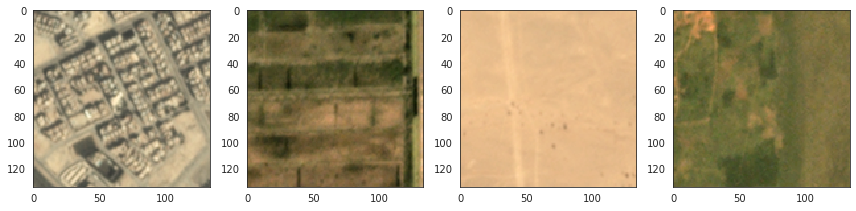

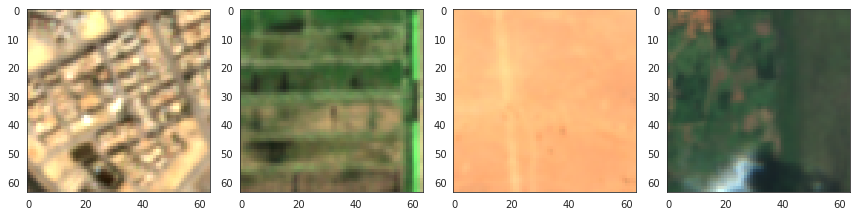

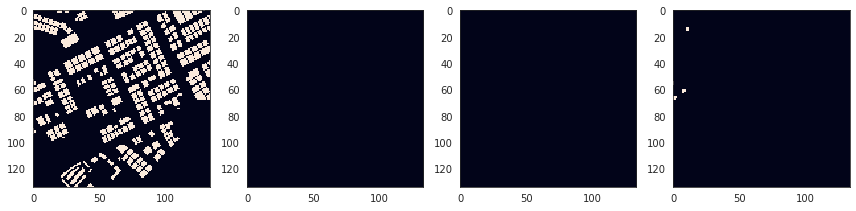

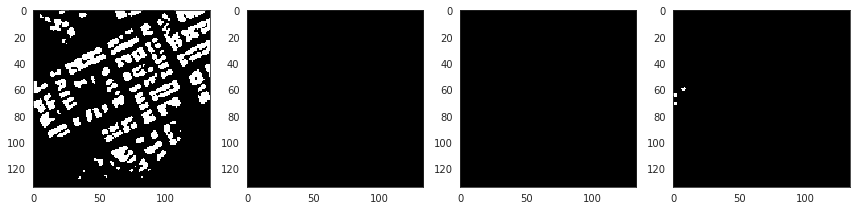

In [24]:
show(hr[20:24].cpu())
show(batch['lowres']['images'][20:24,1,...].cpu())
show(labels[20:24].cpu())
show(sent_out[20:24].cpu())

In [ ]:
print("Mean SSIM MI", (ssim_mi/count).cpu().numpy())
print("Mean SSIM SI", (ssim_si/count).cpu().numpy())
print("Mean PSNR MI", (psnr_mi/count).cpu().numpy())
print("Mean PSNR SI", (psnr_si/count).cpu().numpy())

In [ ]:
date_range = pd.date_range(start=f"2019-12-30", end=f"2020-01-31")
dm = SN7DataModule(date_range=date_range,s2_bands=range(12), window_size_planet=134, force_size=64, samples=7500,
                   batch_size=args.batch_size, normalize=True, standardize_sentinel=False, labels=True, collate_2toN=True, debug=True)
dm.setup()

In [ ]:
for batch in dm.train_dataloader():
    break

In [ ]:
batch['lowres']['images'][0,0,:,:5,:5]